In [61]:
import numpy as np
from matplotlib import pyplot as plt
from utils import *

from matplotlib.patches import Ellipse
from scipy.linalg import eigh
from scipy.stats import chi2

import matplotlib.animation as animation
import matplotlib.pyplot as plt
from tqdm import tqdm


cornflowerblue_alpha = (0.39215686274509803, 0.5843137254901961, 0.9294117647058824, 0.3)

def rgba_to_rgb(rgba, bg=(1, 1, 1)):
    r, g, b, a = rgba
    bg_r, bg_g, bg_b = bg
    
    # Blend the RGBA color with the background color
    r = r * a + bg_r * (1 - a)
    g = g * a + bg_g * (1 - a)
    b = b * a + bg_b * (1 - a)

    return (r, g, b)

def conf_ellipse(ax, center, covariance, alpha=0.95):
    chi2_quantile = chi2.ppf(alpha, 2)
    eigvals, eigvecs = eigh(covariance)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigvals[0] * chi2_quantile), 2 * np.sqrt(eigvals[1] * chi2_quantile)
    ell = Ellipse(xy=center, width=width, height=height, angle=angle, fill=True, facecolor=rgba_to_rgb(cornflowerblue_alpha))
    ax.add_artist(ell)

In [62]:
true_trajectory, noisy_observations = generate_trajectory_nonlinear()

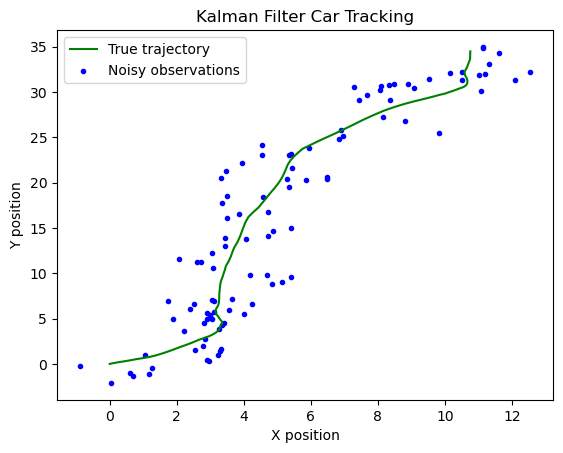

In [63]:
plt.plot(true_trajectory[:, 0], true_trajectory[:, 1], 'g-', label='True trajectory')
plt.scatter(noisy_observations[:, 0], noisy_observations[:, 1], c='b', marker='.', label='Noisy observations')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.legend()
plt.title('Kalman Filter Car Tracking')
plt.show()

In [64]:
from numpy.random import uniform
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
from numpy.random import randn
import scipy.stats
from tqdm import tqdm
from scipy.stats import multivariate_normal as mvn

def systematic_resampling(weights):
    N = len(weights)
    positions = (np.arange(N) + np.random.random()) / N
    indexes = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes


P = np.eye(4)
m = true_trajectory[0]
estimated_trajectory_particle = np.empty((len(noisy_observations), len(m)))
estimated_trajectory_particle[0] = m

P_particle = np.zeros((len(noisy_observations), len(m), len(m)))
P_particle[0] = P

# Draw N samples from the prior
N = 1000
particles = mvn(m, P).rvs(N)
weights = np.ones(N) / N

particles_hist = np.empty((len(noisy_observations), N, len(m)))
particles_hist[0] = particles

weights_hist = np.empty((len(noisy_observations), N))
weights_hist[0] = weights

# SIR particle filter
for idx, y in tqdm(enumerate(noisy_observations[1:], 1), total=len(noisy_observations[1:])):
    particles = np.array([f(particle) for particle in particles]) + mvn([0, 0, 0, 0], Q).rvs(N)
    
    # Update weights
    for i, particle in enumerate(particles):
        pi_dist = scipy.stats.multivariate_normal(h(particle), R)
        weights[i] *= pi_dist.pdf(y)
        
    weights += 1.e-300 # avoid round-off to zero
    weights /= sum(weights)
    
    if 1. / np.sum(np.square(weights)) < N / 2:
        indexes = systematic_resampling(weights)
        
        # Resample from index
        particles[:] = particles[indexes]
        weights.resize(len(particles))
        weights.fill(1.0 / len(weights))

    m = np.average(particles, weights=weights, axis=0)
    # Calculate covariance matrix of particles
    P = np.zeros((4, 4))
    for particle, weight in zip(particles, weights):
        diff = (particle - m)[np.newaxis]
        P += weight * np.dot(diff.T, diff)
    
    estimated_trajectory_particle[idx] = m
    P_particle[idx] = P
    particles_hist[idx] = particles
    weights_hist[idx] = weights

100%|██████████| 100/100 [00:20<00:00,  4.81it/s]


In [77]:
estimated_trajectory_particle_smoothed = estimated_trajectory_particle.copy()
P_particle_smoothed = P_particle.copy()
particles_hist_smoothed = particles_hist.copy()
weights_hist_smoothed = weights_hist.copy()

indices = np.random.choice(np.arange(N), size=N, p=weights_hist_smoothed[-1])
particles_hist_smoothed[-1] = particles_hist_smoothed[-1][indices]

for k in tqdm(range(len(noisy_observations) - 2, -1, -1)):
    for i in range(N):
        weights_hist_smoothed[k, i] *= mvn(particles_hist_smoothed[k + 1, i], P_particle_smoothed[k + 1]).pdf(particles_hist_smoothed[k, i])
    weights_hist_smoothed[k] += 1.e-300 # avoid round-off to zero
    weights_hist_smoothed[k] /= sum(weights_hist_smoothed[k])
    
    if 1. / np.sum(np.square(weights_hist_smoothed[k])) < N / 2:
        indices = systematic_resampling(weights_hist_smoothed[k])
        
        # Resample from index
        particles_hist_smoothed[k] = particles_hist_smoothed[k][indices]
        weights_hist_smoothed[k].resize(len(particles_hist_smoothed[k]))
        weights_hist_smoothed[k].fill(1.0 / len(weights_hist_smoothed[k]))
    
    else:
        indices = np.random.choice(np.arange(N), size=N, p=weights_hist_smoothed[k])
        particles_hist_smoothed[k] = particles_hist_smoothed[k][indices]
    
    estimated_trajectory_particle_smoothed[k] = np.average(particles_hist_smoothed[k], weights=weights_hist_smoothed[k], axis=0)
    
    P = np.zeros((4, 4))
    for particle, weight in zip(particles_hist_smoothed[k], weights_hist_smoothed[k]):
        diff = (particle - estimated_trajectory_particle_smoothed[k])[np.newaxis]
        P += weight * np.dot(diff.T, diff)
        
    P_particle_smoothed[k] = P
    

  3%|▎         | 3/100 [00:00<00:29,  3.34it/s]


LinAlgError: When `allow_singular is False`, the input matrix must be symmetric positive definite.

In [75]:
for i, P in enumerate(P_particle_smoothed):
    # Check if P is positive definite
    if np.all(np.linalg.eigvals(P) > 0):
        pass
    else:
        print(i)
        print('P is not positive definite')
        break

6
P is not positive definite


In [66]:
#Compare methods
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for k in range(2):
    ax[k].plot(true_trajectory[0, 0], true_trajectory[0, 1], 'x', color='k', label="Start")
    ax[k].plot(true_trajectory[:, 0], true_trajectory[:, 1], '--', color='orange', label="True trajectory")
    ax[k].plot(noisy_observations[:, 0], noisy_observations[:, 1], '.', color='orange', label="Noisy observations")
    ax[k].set_xlabel("x")
    ax[k].set_ylabel("y")
    
ax[0].plot(estimated_trajectory_particle[:, 0], estimated_trajectory_particle[:, 1])  
ax[0].set_title("Particle filter")

ax[1].plot(estimated_trajectory_particle_smoothed[:, 0], estimated_trajectory_particle_smoothed[:, 1])
ax[1].set_title("Particle filter")

# Compute MSE
UP1_MSE = np.mean((true_trajectory[:, :2] - estimated_trajectory_particle[:, :2])**2)
UP2_MSE = np.mean((true_trajectory[:, :2] - estimated_trajectory_particle_smoothed[:, :2])**2)

# Show the MSE on the plot in upper right corner
ax[0].text(0.95, 0.95, "MSE: {:.2f}".format(UP1_MSE), horizontalalignment='right', verticalalignment='top', transform=ax[0].transAxes)
ax[1].text(0.95, 0.95, "MSE: {:.2f}".format(UP2_MSE), horizontalalignment='right', verticalalignment='top', transform=ax[1].transAxes)

# # 95% confidence ellipses for the KF
# for i in range(0, len(estimated_trajectory_particle)):
#     #conf_ellipse(ax[0], estimated_trajectory_particle[i, :2], P_particle[i, :2, :2])
#     ax[0].scatter(*particles_hist[i, :, :2].T, s=5, alpha=0.5)

# # 95% confidence ellipses for the EKF
for i in range(0, len(estimated_trajectory_particle)):
    conf_ellipse(ax[0], estimated_trajectory_particle[i, :2], P_particle[i, :2, :2])
    
# # 95% confidence ellipses for the EKF
for i in range(0, len(estimated_trajectory_particle)):
    conf_ellipse(ax[1], estimated_trajectory_particle_smoothed[i, :2], P_particle_smoothed[i, :2, :2])

plt.show()

/tmp/ipykernel_7191/653232931.py:33: RuntimeWarning: invalid value encountered in sqrt
  width, height = 2 * np.sqrt(eigvals[0] * chi2_quantile), 2 * np.sqrt(eigvals[1] * chi2_quantile)


ValueError: need at least one array to concatenate

<Figure size 1500x500 with 2 Axes>

# Animation

In [ ]:
fig = plt.figure(figsize=(6, 6))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])

ax.plot(true_trajectory[0, 0], true_trajectory[0, 1], 'x', color='k', label="Start")
ax.plot(true_trajectory[:, 0], true_trajectory[:, 1], '--', color='orange', label="True trajectory")

ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

line, =  ax.plot([],[], '-', color='black', label="Estimated trajectory")

#    ax.plot(estimated_trajectory_particle[frame, 0], estimated_trajectory_particle[frame, 1], '-', color='black', label="Estimated trajectory")
# Function to initialize the plot
def init():
    ax.set_xlim(int(np.min(noisy_observations[:, 0]) - 5), int(np.max(noisy_observations[:, 0] + 5)))
    ax.set_ylim(int(np.min(noisy_observations[:, 1]) - 5), int(np.max(noisy_observations[:, 1] + 5)))
    ax_histx.set_ylim(0, 1.0)
    ax_histy.set_xlim(0, 1.0)
    return ax,

# Function to update the plot for each frame
def update(frame):
    x = particles_hist[frame, :, 0]  # Select X coordinates of particles at a given time
    y = particles_hist[frame, :, 1]  # Select Y coordinates of particles at a given time
    #ax.scatter(x, y, c='b', marker='.', alpha=0.1)
    ax.plot(noisy_observations[frame, 0], noisy_observations[frame, 1], '.', color='orange', label="Noisy observations")
    conf_ellipse(ax, estimated_trajectory_particle[frame, :2], P_particle[frame, :2, :2])
    
    line.set_xdata(estimated_trajectory_particle[:frame, 0])
    line.set_ydata(estimated_trajectory_particle[:frame, 1])    
    
    ax_histx.clear()
    ax_histy.clear()
    ax_histx.set_ylim(0, 1.5)
    ax_histy.set_xlim(0, 1.5)
    
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    
    ax_histx.hist(x, bins=bins, density=True)
    tmp_x  = np.linspace(estimated_trajectory_particle[frame, 0] - 3 * np.sqrt(P_particle[frame, 0, 0]),
                            estimated_trajectory_particle[frame, 0] + 3 * np.sqrt(P_particle[frame, 0, 0]), 100)
    ax_histx.plot(tmp_x, scipy.stats.norm.pdf(tmp_x, estimated_trajectory_particle[frame, 0], np.sqrt(P_particle[frame, 0, 0])), tmp_x, color='black')    
    
    ax_histy.hist(y, bins=bins, orientation='horizontal', density=True)
    tmp_y  = np.linspace(estimated_trajectory_particle[frame, 1] - 3 * np.sqrt(P_particle[frame, 1, 1]),
                            estimated_trajectory_particle[frame, 1] + 3 * np.sqrt(P_particle[frame, 1, 1]), 100)
    ax_histy.plot(scipy.stats.norm.pdf(tmp_y, estimated_trajectory_particle[frame, 1], np.sqrt(P_particle[frame, 1, 1])), tmp_y, color='black')
    
    return ax,

# Save animation with progress bar
with tqdm(total=len(particles_hist)) as pbar:
    ani = animation.FuncAnimation(fig, update, frames=range(0, len(particles_hist)), init_func=init)
    ani.save('particle.gif', writer='Pillow', fps=7, progress_callback=lambda i, n: pbar.update())